# FIXME

1. [x] Clean up the file
  - [x] Clean up the imports
  - [x] Clean up the helper functions - ultimately these should use the libraries
  - [x] Clean up the plots
2. [ ] Figure out exactly which variables need to be swept over
  - [ ] The required variables are apr, time, and the percent of the bond ratio.
  - [ ] Are share price and initial share price essential? What we can do is start without them and see how bad the approximation is with non-trivial values.
3. [ ] Write the sweeping logic and sanity check it
4. [ ] Write the naive interpolation logic
5. [ ] Measure the error for random points on the interpolation space
6. [ ] Attempt to develop a better approximation using the methods from Remco's blogpost
7. [ ] Ensure that our approximation never overshoots. This is currently a problem, which will given inaccurate results.

# Methods

We desire an approximation for the maximum amount of bonds that a trader can short given the ratio of their cash balance to the AMMs cash reserve. To do this, we can calculate the maximum loss for short positions opened with a range of APRs, time remaining, and ratios of bonds to the total bond reserves. For a fixed APR and time remaining, we'll have an array of the maximum loss and the bond ratios shorted. We can find an approximation that tightly fits these points, which is a function of a max loss in base that outputs the ratio of bonds required to hit the max loss.

## TODO - Add detail about the interpolation.

In [304]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg.special_matrices import math
from scipy.optimize import curve_fit

In [305]:
def calc_k_const(share_reserves, bond_reserves, share_price, init_share_price, time_remaining):
    """Returns the 'k' constant variable for trade mathematics"""
    scale = share_price / init_share_price
    return scale * (init_share_price * share_reserves) ** (1 - time_remaining) + (bond_reserves) ** (
        1 - time_remaining
    )

def calc_bond_reserves(share_reserves, apr, share_price, init_share_price, time_remaining):
    """Calculates the bond reserves from the share reserves and a target apr"""
    return (init_share_price * share_reserves) * (1 + apr * time_remaining) ** (1 / time_remaining)

# FIXME: This doesn't incorporate fees
def calc_max_loss(share_reserves, bond_reserves, d_bonds, share_price, init_share_price, time_remaining):
    k = calc_k_const(share_reserves, bond_reserves, share_price, init_share_price, time_remaining)
    d_shares = share_reserves - (1 / init_share_price) * ((init_share_price / share_price) * (k - (bond_reserves + d_bonds) ** (1 - time_remaining))) ** (1 / (1 - time_remaining))
    return d_bonds - d_shares

def calc_max_loss_from_apr(share_reserves, bond_percentage, apr, share_price, init_share_price, time_remaining):
    bond_reserves = calc_bond_reserves(share_reserves, apr, share_price, init_share_price, time_remaining)
    d_bonds = bond_reserves * bond_percentage
    return calc_max_loss(share_reserves, bond_reserves, d_bonds, share_price, init_share_price, time_remaining)

# FIXME: Comment this
# FIXME: Is there a cleaner way to accomplish this using numpy?
def calc_chebyshev_nodes(start, end, num_points):
    i = np.arange(num_points + 1)
    return ((start + end) / 2) + ((end - start) / 2) * np.cos(((2 * i + 1) / (2 * num_points)) * np.pi)


In [306]:
# FIXME: We may not need to sweep over c, mu, and z.
# Simulation Variables
c = 1           # share price
mu = 1          # init share price
z = 10**6       # share reserves -- this is arbitrary for this analysis
apr = 0.02      # apr
t = 0.5         # time remaining
y_percent = 0.1 # percent of bond reserves to be shorted

# Other Variables
verbose = False

In [307]:
# FIXME: This will ultimately be where the sweep code lives.
# FIXME: We should be able to start at zero. We may need to add a constant term
#        to the log.
 
# Capture an array of max losses (the x component) and the bond ratios (the y component) 
# that require the max losses.

# FIXME: This isn't working correctly
y = calc_chebyshev_nodes(0, 100, 100)
x = (calc_max_loss_from_apr(z, 0.1 * y, apr, c, mu, t) / z) * 100
if verbose:
    print(
        f"max loss = {x}"
        f"\nbond percentages = {y}"
    )

Text(0, 0.5, 'Bond Percent')

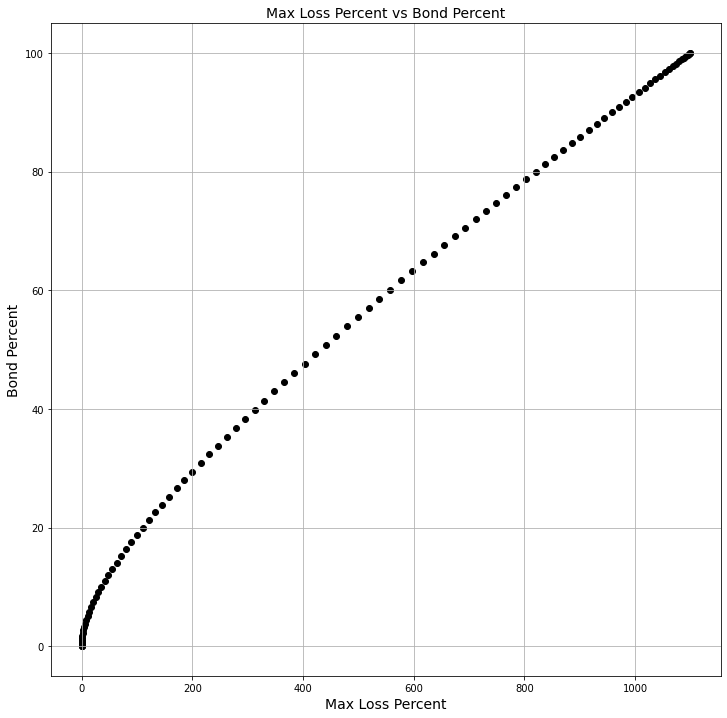

Text(0, 0.5, 'Bond Percent')

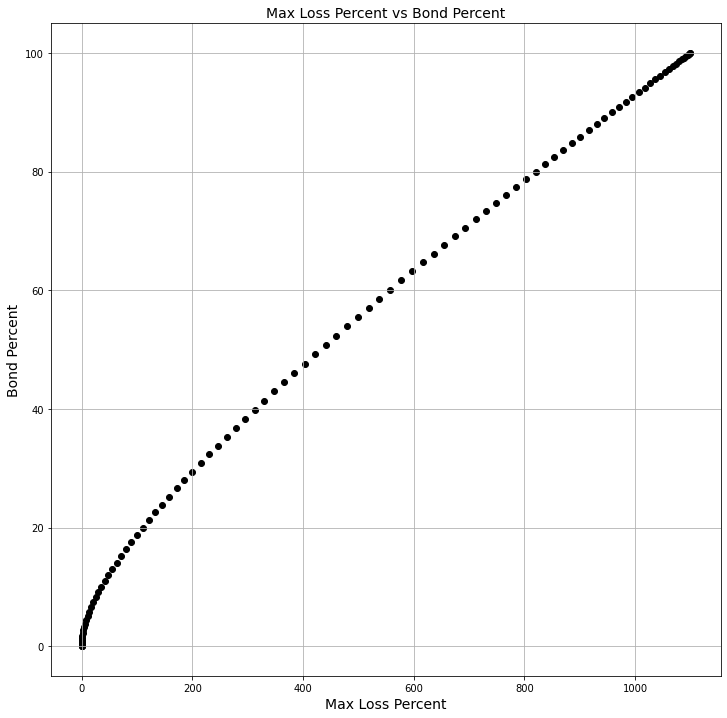

In [308]:
# Plot the raw data output by the sweep
plt.subplots(figsize=(12,12))
plt.scatter(x,y,color='black')
plt.grid(True)
plt.title('Max Loss Percent vs Bond Percent', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Bond Percent', fontsize=14)

In [309]:
# FIXME: Compare results
# Approximate the data with a Chebyshev polynomial
#f_approx = np.polynomial.Chebyshev.fit(x, y, deg=20)

# FIXME: Rational approximation - (2, 2) worked well - (3, 3) worked better - 4 is bad - (4, 5) is great
def rational_objective(xp, p_1, p_2, p_3, p_4, p_5, p_6, p_7, p_8, p_9, p_10, p_11, p_12):
    return (p_1 + p_2 * xp + p_3 * xp ** 2 + p_4 * xp ** 3 + p_5 * xp ** 4) / (1 + p_8 * xp + p_9 * xp ** 2 + p_10 * xp ** 3 + p_11 * xp ** 4 + p_12 * xp ** 5)
popt, _ = curve_fit(rational_objective, x, y)
p_1, p_2, p_3, p_4, p_5, p_6, p_7, p_8, p_9, p_10, p_11, p_12 = popt
print(f"y = ({p_1} + {p_2} * x + {p_3} * x ** 2) / (1 + {p_4} * x + {p_5} * x ** 2)")
def f_approx(xp):
    return rational_objective(xp, p_1, p_2, p_3, p_4, p_5, p_6, p_7, p_8, p_9, p_10, p_11, p_12)

#def polynomial_objective(xp, a, b):
#    return a * xp ** b
#popt, _ = curve_fit(polynomial_objective, x, y)
#a, b = popt
#def f_approx(xp):
#    return polynomial_objective(xp, a, b)

y = (0.023469143034719177 + 4.097174864741624 * x + 2.6930653224595953 * x ** 2) / (1 + 0.10088168118968457 * x + 0.00033854817540307345 * x ** 2)


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


y = (0.023469143034719177 + 4.097174864741624 * x + 2.6930653224595953 * x ** 2) / (1 + 0.10088168118968457 * x + 0.00033854817540307345 * x ** 2)


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [310]:
# Construct a new trace of sample data to test for the error
y_test = np.arange(0, 100, 0.01)
x_test = (calc_max_loss_from_apr(z, 0.1 * y_test, apr, c, mu, t) / z) * 100
y_approx = f_approx(x_test)

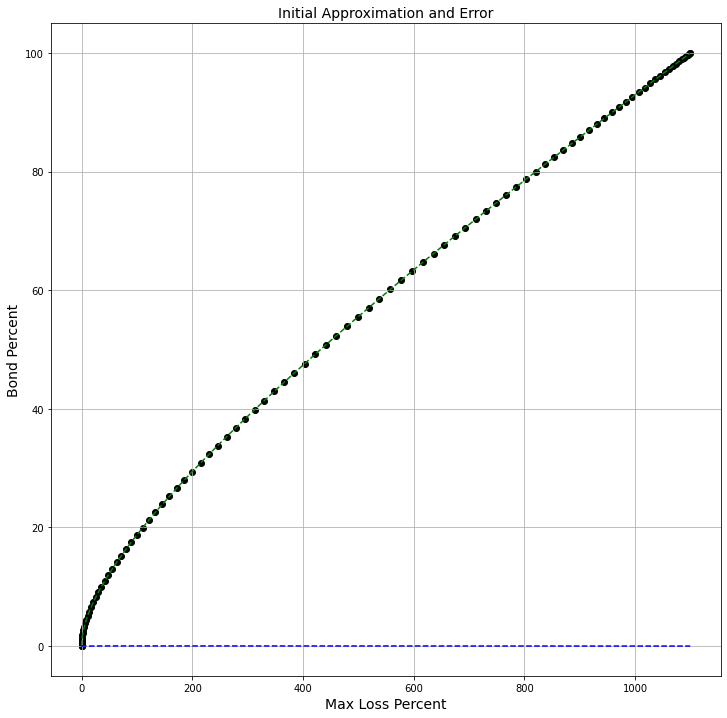

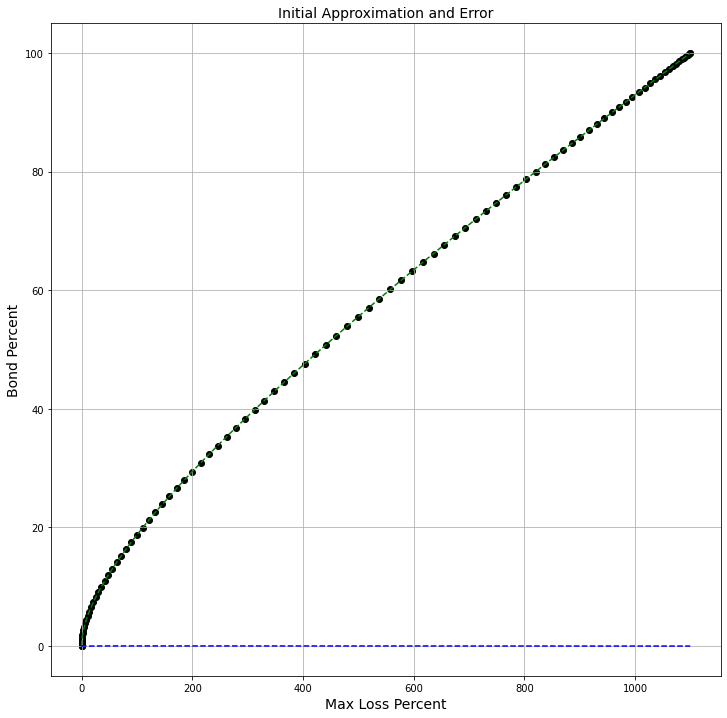

In [311]:
# Plot the Chebyshev approximation against the raw data
plt.subplots(figsize=(12,12))
plt.scatter(x,y,color='black')
# FIXME: It would be good to showcase the fact that we are using different sample data when testing for error.
# plt.scatter(x_test,y_test,color='red')
plt.grid(True)
plt.title('Initial Approximation and Error', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Bond Percent', fontsize=14)

plt.plot(x_test, y_approx, '--', color="green")
plt.plot(x_test, y_test - y_approx, '--', color="blue")

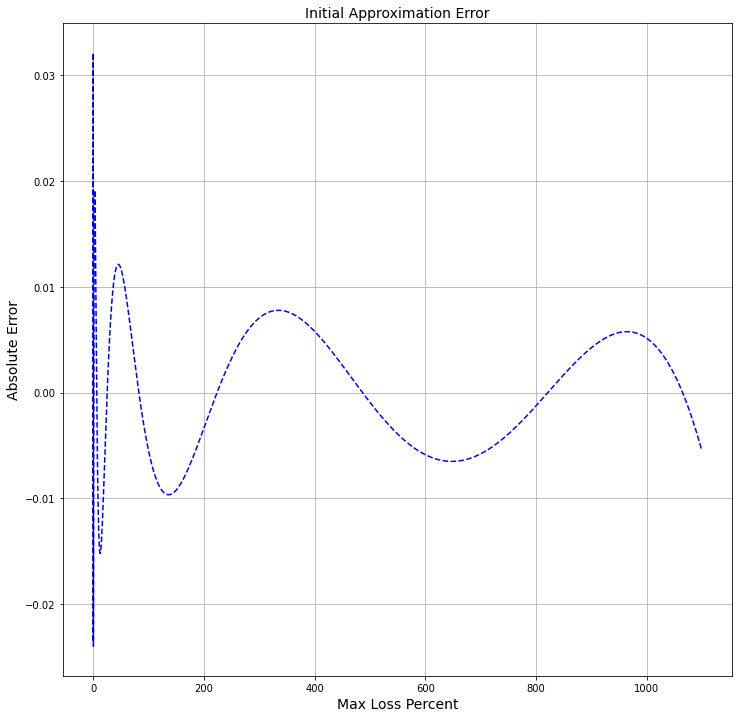

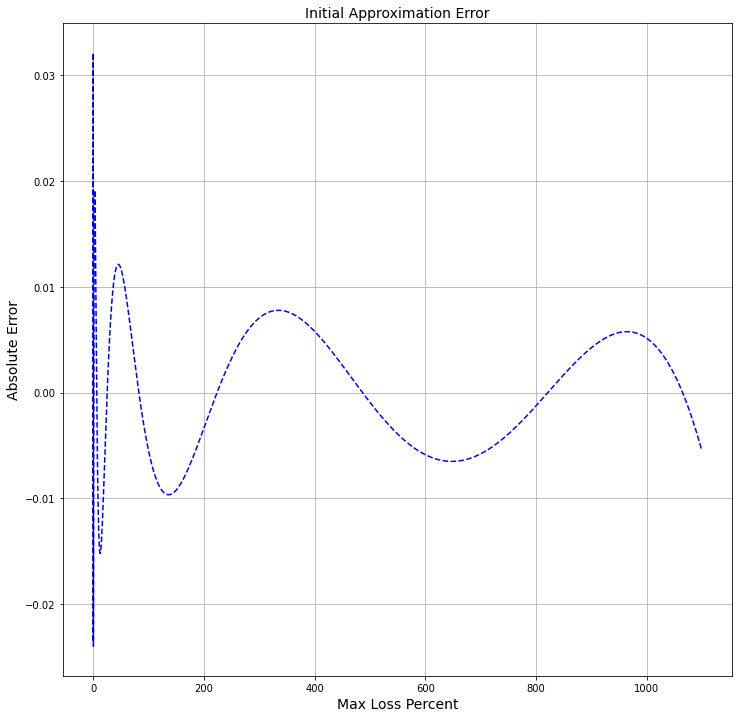

In [312]:
# Plot the absolute error from the initial Chebyshev polynomial
plt.subplots(figsize=(12,12))
plt.grid(True)
plt.title('Initial Approximation Error', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)

plt.plot(x_test, y_test - y_approx, '--', color="blue")